# Gaussian Filter for [OII] Doublet Detection

### Author: Tanveer Karim
### Last Updated: 16 April 2018

This is a toy problem to create a Gaussian filter to detect [OII] doublets $(\lambda 3727-3729$ $\mathring{A})$ for the Dark Energy Spectroscopic Instrument (DESI) Emission-Line-Galaxy (ELG) target selection. The goal is to pass the Gaussian filter over 1-D spectra obtained from the MMT and detect the existence of (if any) O II doublets.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
def Model(params, Amp = 1, std = 0.75): #Default, A = 1, std = 0.75
    """Returns the [OII] doublet model
    Parameters: Amp Amplitude
                params: tuple of spectra and lambda0 (centre point of the Model)
    """
    
    spectra, lambda0 = params
    Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)
    
    #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
    separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
    
    return Amp*(Gaussian(spectra, lambda0-separation, std) + Gaussian(spectra, lambda0+separation, std))

Assume that x values are in $\mathring{A}$. Thus, the two Gaussians are centred at 3727 and 3729 respectively. We pick the width of the Gaussians to be $3/4 \mathring{A}$ a priori because $1.5 \mathring{A}$ might result in the Gaussians being too close to each other.

### SNR calculator

This script will go through the synthetic data and determine SNR at each $\lambda_{0}$ to determine emission lines.

In [5]:
def SNR_Calculator(wavelength, flux, err):
    """Returns the SNR and lambda0 such that SNR is a function of lambda0
    Parameters: wavelength: array of wavelength range over which to test the filter
                flux: array of flux corresponding to the wavelength range
                err: array of flux error
                
    Returns: SNR: Signal-to-noise ratios of Amplitude
             lambda0: Different central values of the filter
    """
    
    lambda0_emitted = 3727.092 + (3729.875-3727.092)/2 #Midpoint of OII doublet
        
    #Initialise numpy arrays
    width = np.arange(0.1, 2.1, .1) #To calculate SNR at different linewidth
    z = np.zeros(len(wavelength))
    SNR = np.zeros((len(width), len(wavelength))) #width vs z grid
    dataPrime = flux/err #signal of data
    
    #Calculate SNR at different lambda0 and w
    for i in range(len(wavelength)):
        for j in range(len(width)):
            lambda0 = wavelength[i]
            modelFlux = Model((wavelength, lambda0), 1, width[j])
            modelPrime = modelFlux/err
            
            """A = (fluxPrime (dot) modelPrime)/(modelPrime (dot) modelPrime)
            sigmaA = 1/sqrt(modelPrime (dot) modelPrime)
            SNR = A/sigmaA"""
            sigmaA = 1./np.sqrt(np.dot(modelPrime, modelPrime))
            A = np.dot(dataPrime, modelPrime)/(sigmaA**(-2))
            SNR[j][i] = A/sigmaA
            
        #Convert lambda0 to z
        z[i] = lambda0/lambda0_emitted - 1
    
    return SNR, z, width

### Synthetic spectra

Now we generate synthetic spectra and test the model on it

Text(0,0.5,'Flux Error')

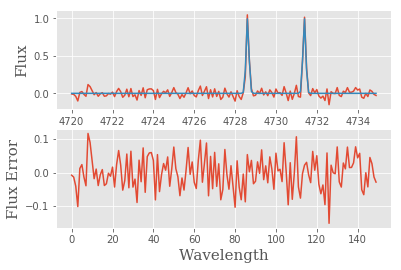

In [20]:
synthSpectra = np.arange(4720, 4735, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model((synthSpectra, 4730), 1, .1)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

[Text(33,0.5,'Line width w'), Text(0.5,15,'Redshift z')]

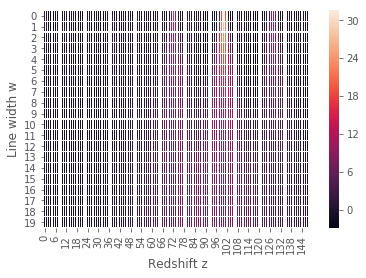

In [18]:
SNR, z, w = SNR_Calculator(synthSpectra, synthData, errstd)
ax = sns.heatmap(SNR, linewidth=0.1)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

Text(0,0.5,'SNR')

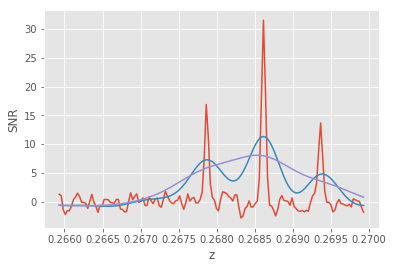

In [19]:
plt.plot(z, SNR[0])
plt.plot(z, SNR[10])
plt.plot(z, SNR[19])
plt.xlabel("z")
plt.ylabel("SNR")

### Synthetic Spectra 2

Here, we will inject a simple Gaussian signal and a double Gaussian signature and test the SNR_calculator function

Text(0,0.5,'Flux Error')

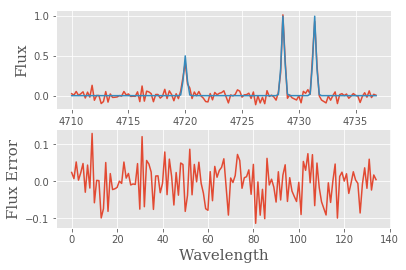

In [37]:
Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)

synthSpectra = np.arange(4710, 4737, .2)
pureData = Model((synthSpectra, 4730), 1, .2) + 0.5*Gaussian(synthSpectra, 4720, .2)
errstd = 0.05
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData)
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

[Text(33,0.5,'Line width w'), Text(0.5,15,'Redshift z')]

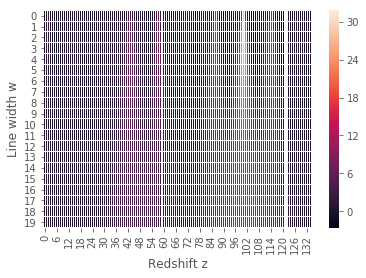

In [38]:
SNR, z, w = SNR_Calculator(synthSpectra, synthData, errstd)
ax = sns.heatmap(SNR, linewidth=0.01)#, xticklabels=z, yticklabels=w)
ax.set(xlabel='Redshift z', ylabel='Line width w')

Text(0,0.5,'SNR')

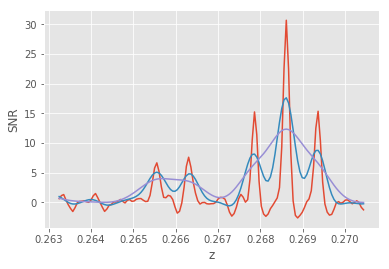

In [39]:
plt.plot(z, SNR[2])
plt.plot(z, SNR[10])
plt.plot(z, SNR[19])
plt.xlabel("z")
plt.ylabel("SNR")

In [9]:
from utils import bino_data_preprocess

In [10]:
data, header = bino_data_preprocess("../../data/v1/st82-1hr-600/obj_abs_slits_lin.fits", 
                                    "../../data/v1/st82-1hr-600/obj_abs_err_slits_lin.fits")

In [11]:
df = data[48][0]
errdf = data[48][1]

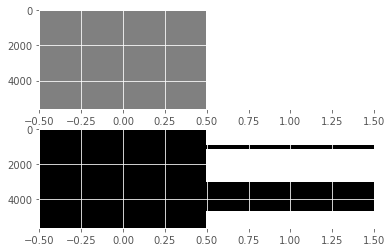

In [12]:
plt.subplot(2, 1, 1)
plt.imshow(df, aspect = 'auto',  vmin=-4, vmax=4, cmap = 'gray', interpolation = 'None')
#plt.xlim([3720, 4200])
#plt.xlim([2900, 3100]) #To find the central region of the brightest blob

plt.subplot(2, 1, 2)
plt.imshow(errdf,  vmin=-4, vmax=4, aspect = 'auto', cmap = 'gray', interpolation = 'None')

#plt.xlim([3720, 4200])
#plt.xlim([2900, 3100]) #To find the central region of the brightest blob